# Multi-layer Perceptron (Fully Connected Feedforward Neural Network)
## **Handwritten Digits Classifier**



This notebook demonstrates how to train a simple neural network on the MNIST dataset using PyTorch. We'll visualize data before and after training, and explain each step clearly.

In [14]:
# @title Dependencies
!pip install torch
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [15]:
# @title Training device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


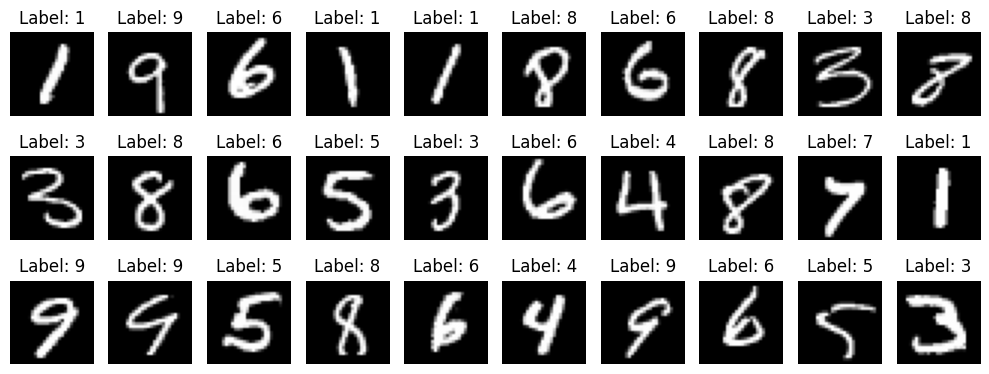

In [16]:
# @title Dataset

# Download datasets
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Helper function to visualize a random subset of the dataset
def show_images(images, labels, predictions = None):
    plt.figure(figsize=(10, 4))
    for i in range(30):
        plt.subplot(3, 10, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        title = f"Label: {labels[i]}"
        if predictions is not None:
            title += f"\nPred: {predictions[i]}"
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample training images
sample_images, sample_labels = next(iter(train_loader))
show_images(sample_images, sample_labels)

In [17]:
# @title Network architecture
class DigitNet(nn.Module):
    def __init__(self, input_size: int = 28) -> None:
        super().__init__()
        self.flat_size = input_size**2
        self.fc1 = nn.Linear(self.flat_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, self.flat_size)              # Flattened input
        x = torch.relu(self.bn1(self.fc1(x)))       # ReLU activation
        x = torch.relu(self.bn2(self.fc2(x)))       # ReLU activation

        return self.fc3(x)                          # Output, raw logits (no activation)

In [18]:
# @title Model initialization

model = DigitNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# @title Training
epochs = 25
for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], step [{i+1}], loss: {loss.item():.4f}")

    print(f"\nEpoch [{epoch+1}] finished with avg loss: {running_loss / len(train_loader):.4f}\n")

Epoch [1/25], step [200], loss: 0.3508
Epoch [1/25], step [400], loss: 0.2740
Epoch [1/25], step [600], loss: 0.2031
Epoch [1/25], step [800], loss: 0.1543

Epoch [1] finished with avg loss: 0.2559

Epoch [2/25], step [200], loss: 0.0658
Epoch [2/25], step [400], loss: 0.1685
Epoch [2/25], step [600], loss: 0.0166
Epoch [2/25], step [800], loss: 0.0372

Epoch [2] finished with avg loss: 0.0949

Epoch [3/25], step [200], loss: 0.1756
Epoch [3/25], step [400], loss: 0.0994
Epoch [3/25], step [600], loss: 0.0219
Epoch [3/25], step [800], loss: 0.0794

Epoch [3] finished with avg loss: 0.0690

Epoch [4/25], step [200], loss: 0.1382
Epoch [4/25], step [400], loss: 0.0639
Epoch [4/25], step [600], loss: 0.0656
Epoch [4/25], step [800], loss: 0.0579

Epoch [4] finished with avg loss: 0.0536

Epoch [5/25], step [200], loss: 0.0519
Epoch [5/25], step [400], loss: 0.0138
Epoch [5/25], step [600], loss: 0.0154
Epoch [5/25], step [800], loss: 0.0198

Epoch [5] finished with avg loss: 0.0430

Epoch

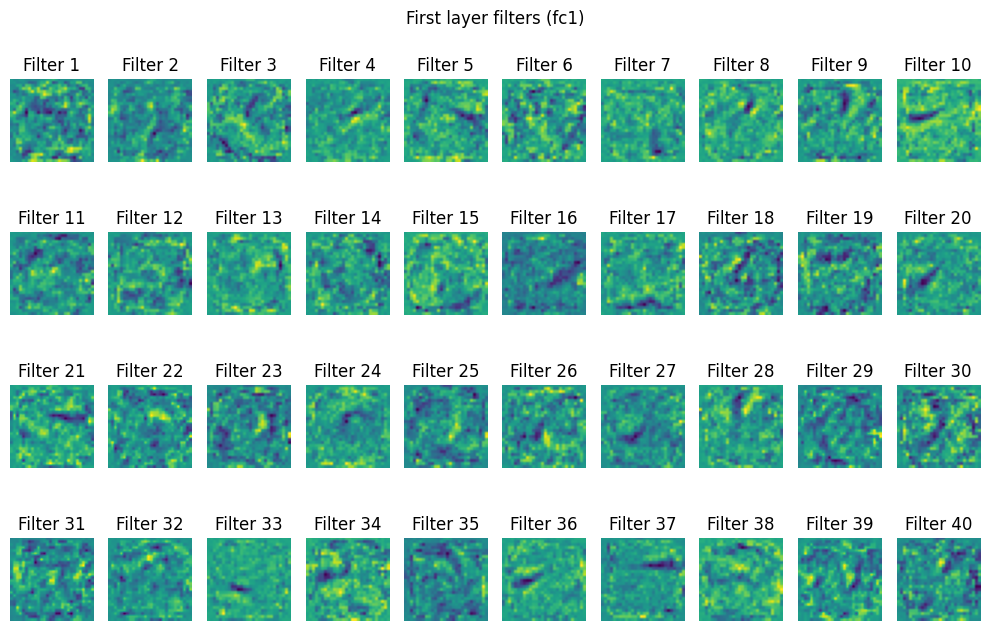

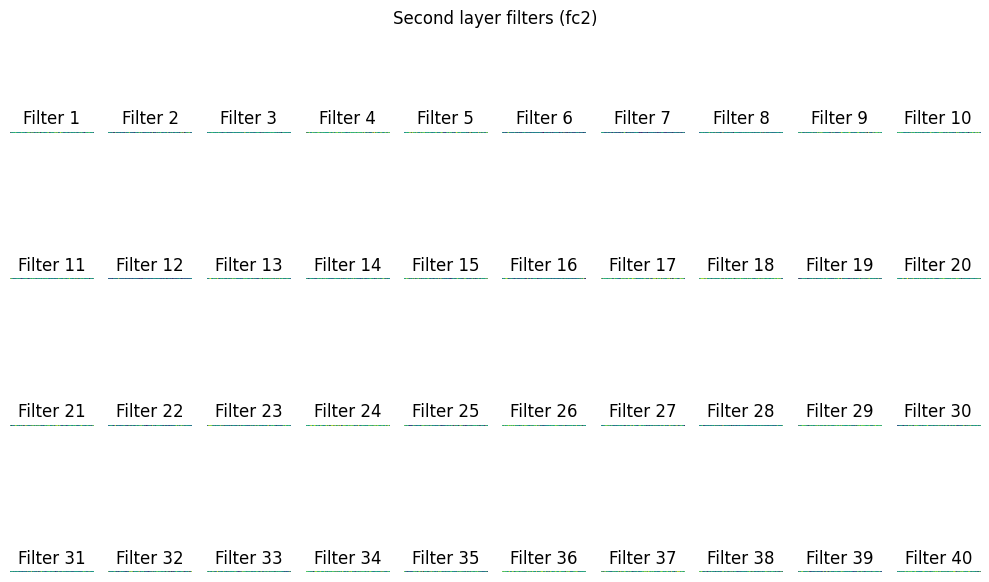

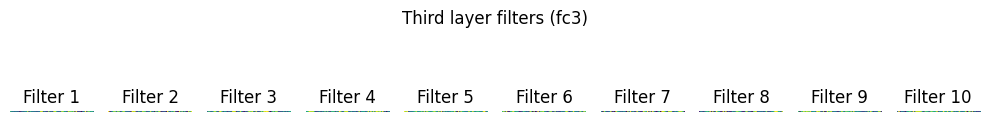

In [24]:
# @title Visualizing learned filters
def visualize_filters(layer, shape=(28, 28), max_filters=40, title="Learned filters"):
    """
    Visualize the filters (weights) of a given linear layer.

    :param layer: the `nn.Linear` layer whose filters to visualize.
    :param shape: the 2D shape to reshape each filter into (e.g., (28, 28)).
    :param max_filters: maximum number of filters to display.
    :param title: title of the plot.
    """
    weights = layer.weight.data.cpu().numpy()
    num_filters = min(max_filters, weights.shape[0])
    plt.figure(figsize=(10, 8))
    for i in range(num_filters):
        plt.subplot(5, 10, i + 1)
        try:
            plt.imshow(weights[i].reshape(shape), cmap='viridis')
        except ValueError:
            # fallback to 1D plot if the shape doesn't match
            plt.plot(weights[i])
        plt.title(f"Filter {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# Visualize first layer (fc1) filters
visualize_filters(model.fc1, shape=(28, 28), title="First layer filters (fc1)")

# Visualize second layer (fc2) filters
# NOTE(abi): 1D plots, since input is no longer 2D.
visualize_filters(model.fc2, shape=(1, 128), title="Second layer filters (fc2)")

# Visualize third layer (fc3) filters
visualize_filters(model.fc3, shape=(1, 64), title="Third layer filters (fc3)")

In [21]:
# @title Evaluation
correct = 0
total = 0
all_preds = []
all_imgs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if len(all_preds) < 10:
            all_preds.extend(predicted.cpu().numpy())
            all_imgs.extend(images.cpu().numpy())

print(f"Accuracy of the model on the test set: {100 * correct / total:.2f}%")

Accuracy of the model on the test set: 97.87%


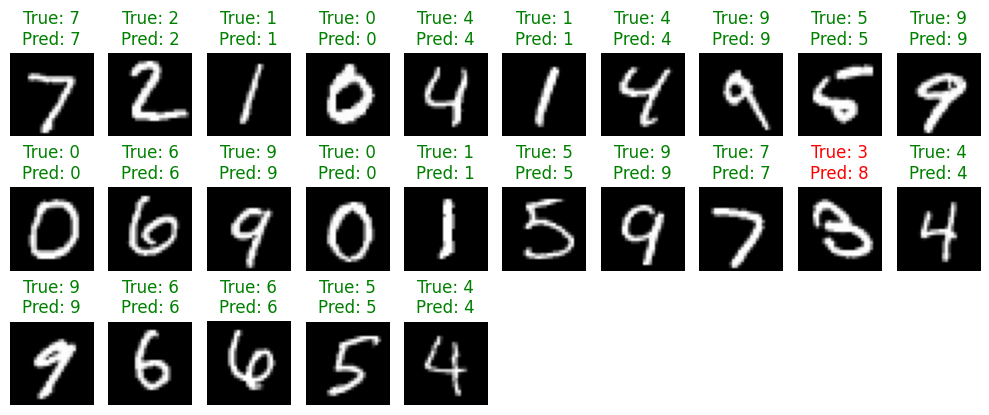

In [22]:
# @title Visualizing predictions

# Plot predictions (color coded)
def visualize_predictions(images, true_labels, predictions, num_images=25):
    plt.figure(figsize=(10, 7))
    for i in range(num_images):
        plt.subplot(5, 10, i+1)
        plt.imshow(images[i][0], cmap='gray')
        color = 'green' if true_labels[i] == predictions[i] else 'red'
        plt.title(f"True: {true_labels[i]}\nPred: {predictions[i]}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Collect more predictions for better visualization
all_imgs = []
all_true = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_imgs.extend(images.cpu().numpy())
        all_true.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        if len(all_imgs) >= 100:
            break

visualize_predictions(all_imgs, all_true, all_preds)

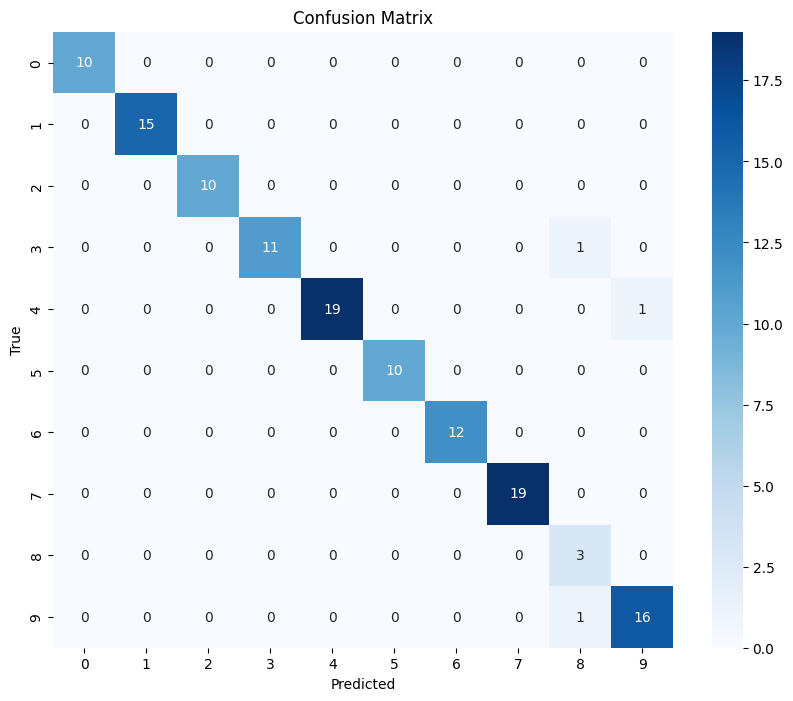

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        10
           3       1.00      0.92      0.96        12
           4       1.00      0.95      0.97        20
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        19
           8       0.60      1.00      0.75         3
           9       0.94      0.94      0.94        17

    accuracy                           0.98       128
   macro avg       0.95      0.98      0.96       128
weighted avg       0.98      0.98      0.98       128



In [23]:
# @title Metrics

# Confusion matrix
def plot_confusion_matrix(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(all_true, all_preds)

# Classification report
print("Classification Report:")
print(classification_report(all_true, all_preds))